In [1]:
#for data analysis and modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for visualization
import matplotlib.pyplot as plt

In [2]:
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape

(44898, 5)

In [5]:
%%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                        "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                        "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                        "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                        "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                        "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                        "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                        "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                        "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                        "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                        "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                        "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                        "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                        "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                        "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                        "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                        "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                        "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                        "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                        "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                        "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt))

CPU times: total: 13.8 s
Wall time: 14.4 s


In [6]:
df['data_cleaned']

0        As US budget fight looms Republicans flip fisc...
1        US military accept transgender recruits Monday...
2          Senior US Republican senator Let Mr Mueller job
3        FBI Russia probe helped Australian diplomat ti...
4        Trump wants Postal Service charge much Amazon ...
                               ...                        
44893    McPain John McCain Furious That Iran Treated U...
44894    JUSTICE Yahoo Settles Email Privacy Classactio...
44895    Sunnistan US Allied Safe Zone Plan Take Territ...
44896    How Blow Million Al Jazeera America Finally Ca...
44897    US Navy Sailors Held Iranian Military Signs Ne...
Name: data_cleaned, Length: 44898, dtype: object

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['truth'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 223


In [8]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: As US budget fight looms Republicans flip fiscal script
sequence of indices(before padding): [1321, 2308, 4057, 191, 412, 2719, 1581, 2382]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

In [9]:
%%time
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   

Size of vocabulary in GloVe: 1917494
CPU times: total: 1min 56s
Wall time: 2min 1s


In [10]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['brexit', 'antitrump', 'reutersipsos', 'protrump', 'blacklivesmatter']


In [11]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

209 out of 10000 words were OOV.


In [12]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3219777 (12.28 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 3000000 (11.44 MB)
_________________________________________________________________
None


In [13]:
%%time
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
141/141 [==============================] - 227s 2s/step - loss: 0.1223 - accuracy: 0.9530 - val_loss: 0.0686 - val_accuracy: 0.9771
Epoch 2/10
141/141 [==============================] - 182s 1s/step - loss: 0.0594 - accuracy: 0.9786 - val_loss: 0.0541 - val_accuracy: 0.9811
Epoch 3/10
141/141 [==============================] - 181s 1s/step - loss: 0.0440 - accuracy: 0.9845 - val_loss: 0.0484 - val_accuracy: 0.9844
Epoch 4/10
141/141 [==============================] - 180s 1s/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0585 - val_accuracy: 0.9804
Epoch 5/10
141/141 [==============================] - 178s 1s/step - loss: 0.0260 - accuracy: 0.9912 - val_loss: 0.0400 - val_accuracy: 0.9873
Epoch 6/10
141/141 [==============================] - 185s 1s/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0427 - val_accuracy: 0.9876
Epoch 7/10
141/141 [==============================] - 187s 1s/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0409 - val_accuracy: 0.9874

Text(0.5, 1.0, 'Accuracy')

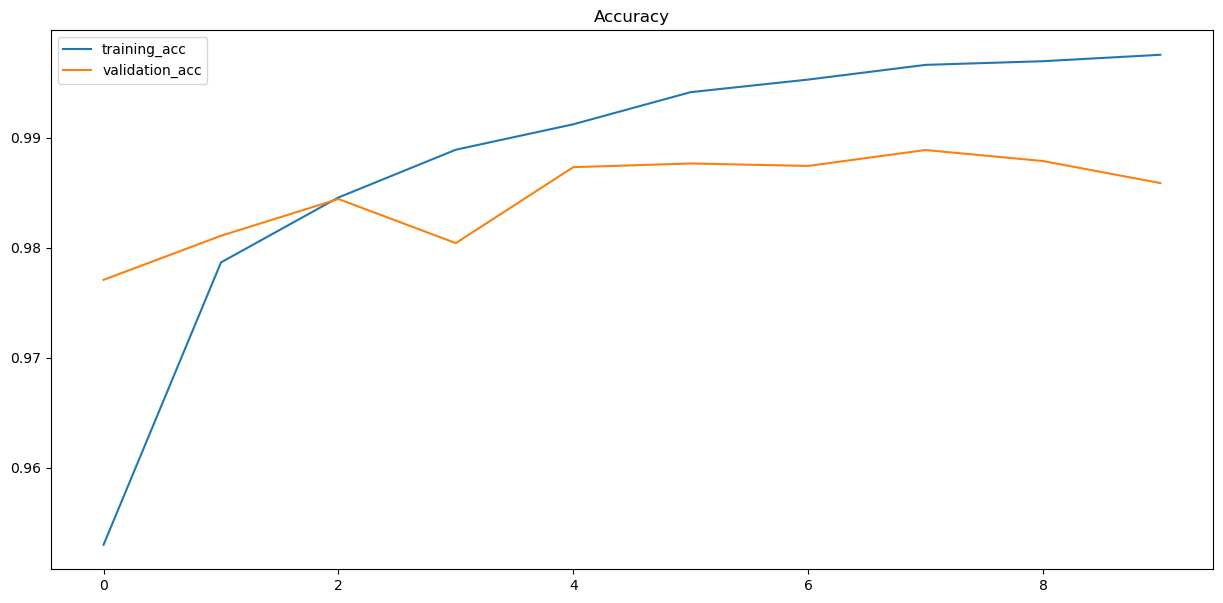

In [14]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [15]:
train_lstm_results = lstm_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 99.65
Test accuracy: 98.59


In [17]:
tf.saved_model.save(lstm_model, 'saved_model/LSTM_model')

INFO:tensorflow:Assets written to: saved_model/LSTM_model\assets


INFO:tensorflow:Assets written to: saved_model/LSTM_model\assets


In [18]:
lstm_model.save('lstm_model.h5')

C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
weights = lstm_model.get_weights()  
with open('lstm_model_weights.bin', 'wb') as f:
    for weight in weights:
        f.write(weight.tobytes()) 


In [22]:
lstm_model.save('lstm_model_keras') 

INFO:tensorflow:Assets written to: lstm_model_keras\assets


INFO:tensorflow:Assets written to: lstm_model_keras\assets


In [24]:
from tensorflow.keras.models import load_model

loaded_model_h5 = load_model('lstm_model.h5')

test_loss_h5, test_accuracy_h5 = loaded_model_h5.evaluate(xtest_pad, ytest, verbose=2)

print(f'Test accuracy using .h5 file: {test_accuracy_h5*100:.2f}%')


281/281 - 14s - loss: 0.0499 - accuracy: 0.9859 - 14s/epoch - 49ms/step
Test accuracy using .h5 file: 98.59%


In [28]:
import tensorflow as tf

loaded_model = tf.saved_model.load('saved_model/LSTM_model')

@tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
def predict(input_data):
    return loaded_model.signatures['serving_default'](embedding_input=input_data)

xtest_pad_float = tf.cast(xtest_pad, tf.float32)

predictions = predict(xtest_pad_float)

test_accuracy = tf.keras.metrics.BinaryAccuracy()
test_accuracy.update_state(ytest, predictions['dense']) 
accuracy = test_accuracy.result().numpy()

print(f'Test accuracy using saved_model: {accuracy*100:.2f}%')


Test accuracy using saved_model: 98.59%


In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

def load_weights_from_bin(file_path, layer_shapes):
    weights = []
    with open(file_path, 'rb') as f:
        for shape in layer_shapes:
            num_elements = np.prod(shape)
            weight_flat = np.frombuffer(f.read(num_elements * 4), dtype=np.float32)
            weight_reshaped = weight_flat.reshape(shape)
            weights.append(weight_reshaped)
    return weights

vocab_len = 10000
emb_dim = 300

layer_shapes = [
    (vocab_len, emb_dim),
    (emb_dim, 512),
    (128, 512),
    (512,),
    (128, 1),
    (1,)
]

loaded_weights = load_weights_from_bin('lstm_model_weights.bin', layer_shapes)

lstm_model_from_weights = Sequential([
    Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model_from_weights.set_weights(loaded_weights)

lstm_model_from_weights.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


281/281 - 27s - loss: 0.0499 - accuracy: 0.9859 - 27s/epoch - 96ms/step
Test accuracy using .bin file: 98.59%
